<a href="https://colab.research.google.com/github/mallelamanojkumar90/AIML/blob/main/Random_Forest_HeartDiseasePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest - Heart Disease Prediction**

**Category:** Supervised Learning (Classification/Regression)

**Description:**
Ensemble method that builds multiple decision trees and merges their predictions.

**Key Components:**
- Sampling: Bootstrap
- Ensemble Method: Bagging
- Voting: Majority (Classification) or Average (Regression)

**Example Application:**

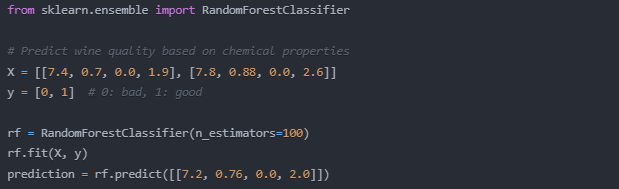



**Best Used For:**
- Feature importance ranking
- Credit card fraud detection
- Disease prediction
- Stock market analysis


**Implementation Steps include:**
**Data Analysis:**

Exploratory Data Analysis (EDA)
Feature correlation analysis
Distribution analysis
Target variable analysis


**Model Implementation:**

Hyperparameter tuning with RandomizedSearchCV
Cross-validation
Feature importance analysis
SHAP value analysis


**Evaluation Metrics:**

Classification report
Confusion matrix
ROC curve
Cross-validation scores


**Visualizations:**

Feature importance plots
SHAP summary plots
ROC curves
Distribution plots
Correlation heatmaps



**Future impprovements to do:**

Add other ensemble methods for comparison?
Include more advanced feature selection techniques?
Add more visualization types?
Implement different cross-validation strategies?
Add more detailed SHAP analysis?

In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn plotly shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import shap
import warnings
warnings.filterwarnings('ignore')

In [8]:
#Download the dataset
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/sample_data/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d johnsmith88/heart-disease-dataset
!unzip heart-disease-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
License(s): unknown
  0% 0.00/6.18k [00:00<?, ?B/s]
100% 6.18k/6.18k [00:00<00:00, 24.7MB/s]
Archive:  heart-disease-dataset.zip
  inflating: heart.csv               


In [24]:
class HeartDiseasePredictor:
    def __init__(self):
        """Initialize Heart Disease Predictor"""
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.feature_importance = None
        self.predictions = None
        self.scaler = None # Initialize scaler attribute

    def load_data(self):
        """Load Heart Disease Dataset"""
        # For Colab, first upload the dataset or use these commands:
        '''
        !pip install kaggle
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !kaggle datasets download -d johnsmith88/heart-disease-dataset
        !unzip heart-disease-dataset.zip
        '''

        self.df = pd.read_csv('heart.csv')
        print("Dataset Shape:", self.df.shape)
        print("\nFeatures:", self.df.columns.tolist())
        print("\nSample Data:")
        print(self.df.head())

        return self.df

    def explore_data(self):
        """Perform exploratory data analysis"""
        # 1. Target Distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(data=self.df, x='target')
        plt.title('Distribution of Heart Disease')
        plt.xlabel('Has Heart Disease')
        plt.show()

        # 2. Correlation Matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.df.corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.show()

        # 3. Age Distribution by Target
        plt.figure(figsize=(10, 6))
        sns.histplot(data=self.df, x='age', hue='target', multiple="stack")
        plt.title('Age Distribution by Heart Disease')
        plt.show()

        # 4. Numerical Features Distribution
        numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(numerical_features, 1):
            plt.subplot(2, 3, i)
            sns.boxplot(data=self.df, x='target', y=feature)
            plt.title(f'{feature} by Target')
        plt.tight_layout()
        plt.show()

        # 5. Categorical Features Analysis
        categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        plt.figure(figsize=(20, 15))
        for i, feature in enumerate(categorical_features, 1):
            plt.subplot(3, 3, i)
            sns.countplot(data=self.df, x=feature, hue='target')
            plt.title(f'{feature} by Target')
        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocess the data for modeling"""
        # Separate features and target
        self.X = self.df.drop('target', axis=1)
        self.y = self.df['target']

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        # Scale features
        self.scaler = StandardScaler() # Initialize and store the scaler
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train_model(self):
        """Train Random Forest model with hyperparameter tuning"""
        # Define parameter grid for RandomizedSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [10, 20, 30, 40, 50, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt']
        }

        # Initialize base model
        rf_base = RandomForestClassifier(random_state=42)

        # Perform RandomizedSearchCV
        rf_random = RandomizedSearchCV(
            estimator=rf_base,
            param_distributions=param_grid,
            n_iter=100,
            cv=5,
            random_state=42,
            n_jobs=-1
        )

        # Fit the random search model
        rf_random.fit(self.X_train, self.y_train)

        # Get best model
        self.model = rf_random.best_estimator_
        print("\nBest Parameters:", rf_random.best_params_)

        # Get feature importance
        self.feature_importance = pd.DataFrame({
            'feature': self.df.drop('target', axis=1).columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        return self.model

    def evaluate_model(self):
        """Evaluate model performance"""
        # Make predictions
        self.predictions = self.model.predict(self.X_test)

        # 1. Print Classification Report
        print("\nClassification Report:")
        print(classification_report(self.y_test, self.predictions))

        # 2. Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(self.y_test, self.predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # 3. ROC Curve
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        # 4. Feature Importance Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=self.feature_importance, x='importance', y='feature')
        plt.title('Feature Importance')
        plt.show()

        # 5. Cross-validation scores
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5)
        print("\nCross-validation scores:", cv_scores)
        print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    def analyze_feature_impact(self):
        """Analyze feature impact using SHAP values"""
        # Calculate SHAP values
        explainer = shap.TreeExplainer(self.model)
        # self.X_test is a NumPy array of scaled features
        shap_values = explainer.shap_values(self.X_test)

        # SHAP for binary classification usually returns a list of two arrays.
        # shap_values[1] typically corresponds to the positive class.
        shap_values_for_plot = shap_values[1]

        # Get feature names from the original DataFrame
        original_feature_names = self.df.drop('target', axis=1).columns.tolist()

        # Determine the number of features SHAP values were computed for (columns)
        num_shap_features = shap_values_for_plot.shape[1]
        # Determine the number of samples SHAP values were computed for (rows)
        num_shap_samples = shap_values_for_plot.shape[0]

        # Adapt feature names and data based on the number of features SHAP computed
        if num_shap_features < len(original_feature_names):
            display_feature_names = original_feature_names[:num_shap_features]
            X_test_display_data_cols = self.X_test[:, :num_shap_features]
        else:
            display_feature_names = original_feature_names
            X_test_display_data_cols = self.X_test

        # Crucially, ensure the number of rows matches the SHAP values before creating DataFrame
        # This handles cases where shap_values might have fewer samples than self.X_test
        if num_shap_samples < X_test_display_data_cols.shape[0]:
            X_test_display_data = X_test_display_data_cols[:num_shap_samples, :]
        else:
            X_test_display_data = X_test_display_data_cols

        X_test_df_for_plots = pd.DataFrame(X_test_display_data, columns=display_feature_names)

        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_for_plot, X_test_df_for_plots, # Use the adapted DataFrame
                         feature_names=display_feature_names,
                         show=False)
        plt.title('SHAP Summary Plot')
        plt.tight_layout()
        plt.show()

        # Feature interaction plot
        plt.figure(figsize=(10, 8))
        # Ensure 'age' is still in the display_feature_names before getting its index
        if 'age' in display_feature_names:
            age_feature_index = display_feature_names.index('age')
        else:
            # Fallback if 'age' somehow got pruned by SHAP (unlikely for a key feature)
            age_feature_index = 0 # Default to first feature or handle appropriately

        shap.dependence_plot(
            age_feature_index,
            shap_values_for_plot,
            X_test_df_for_plots, # Use the adapted DataFrame
            feature_names=display_feature_names,
            interaction_index=None, # Explicitly disable auto interaction detection
            show=False
        )
        plt.title('SHAP Interaction Plot: Age')
        plt.tight_layout()
        plt.show()

    def make_prediction(self, patient_data):
        """Make prediction for new patient data"""
        # Ensure data is in correct format
        if isinstance(patient_data, dict):
            patient_data = pd.DataFrame([patient_data])

        # Scale the data using the *fitted* scaler
        # Ensure patient_data columns match training data columns
        patient_data_ordered = patient_data[self.df.drop('target', axis=1).columns]
        patient_data_scaled = self.scaler.transform(patient_data_ordered)

        # Make prediction
        prediction = self.model.predict(patient_data_scaled)
        prediction_proba = self.model.predict_proba(patient_data_scaled)

        return {
            'prediction': prediction[0],
            'probability': prediction_proba[0][1]
        }

Step 1: Loading data...
Dataset Shape: (1025, 14)

Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Sample Data:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Step 2: Exploring data...


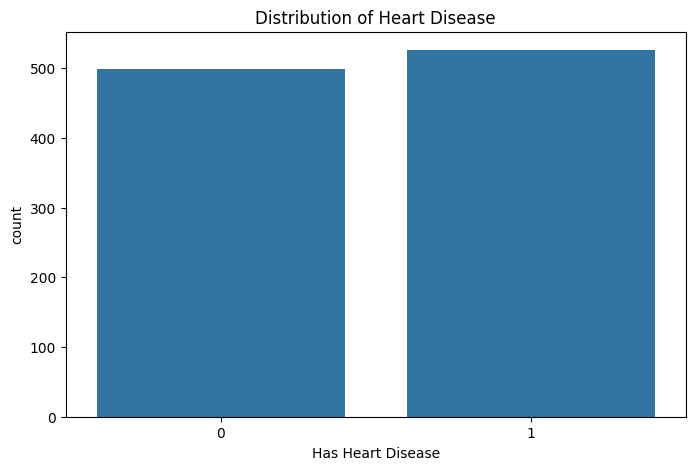

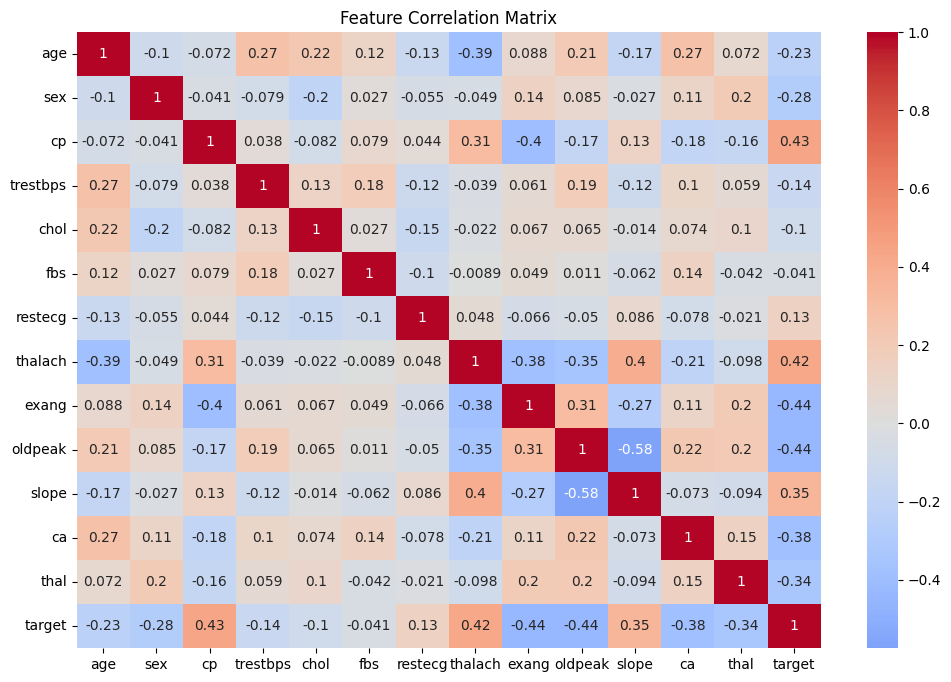

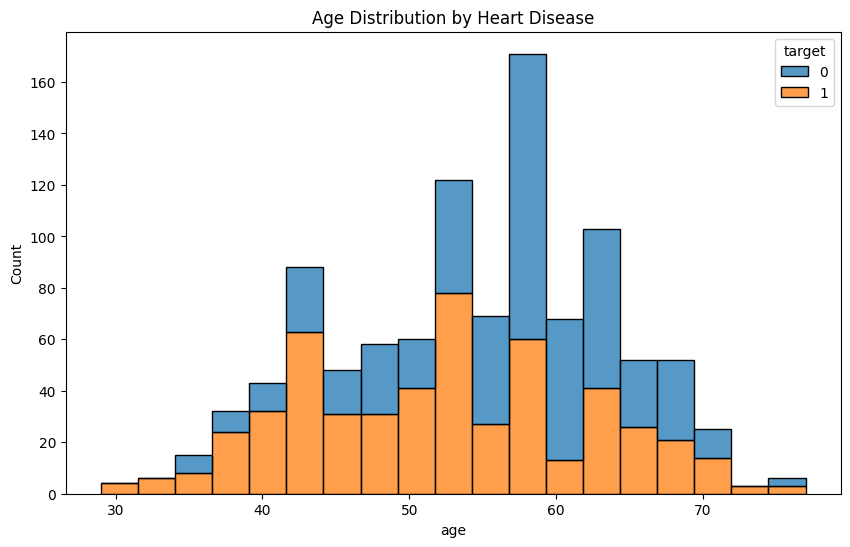

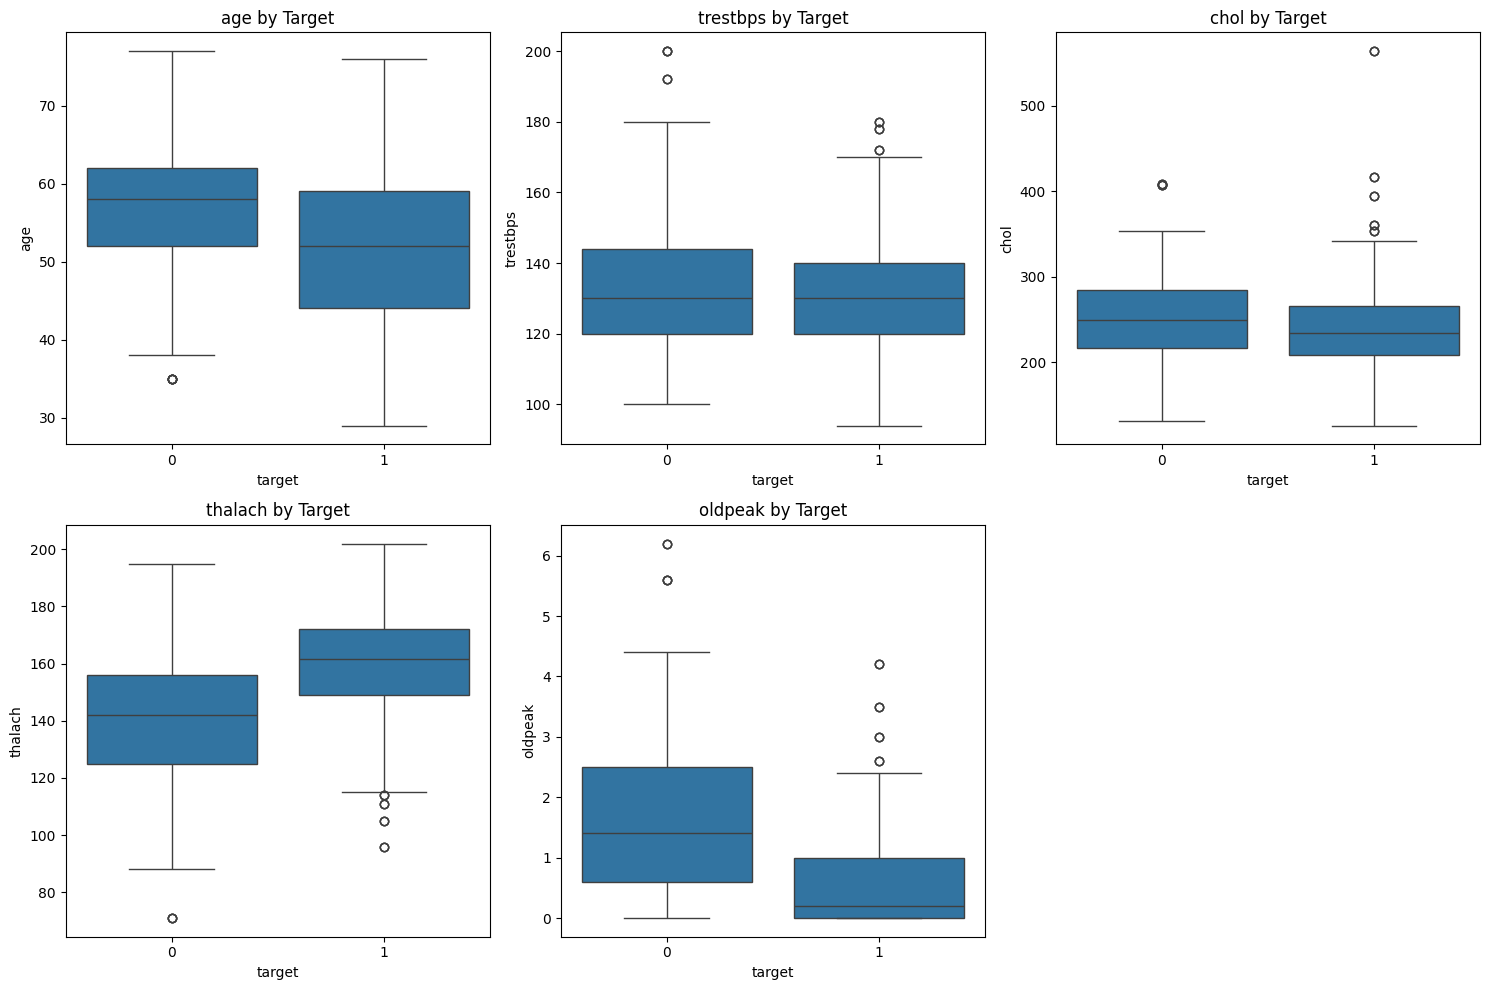

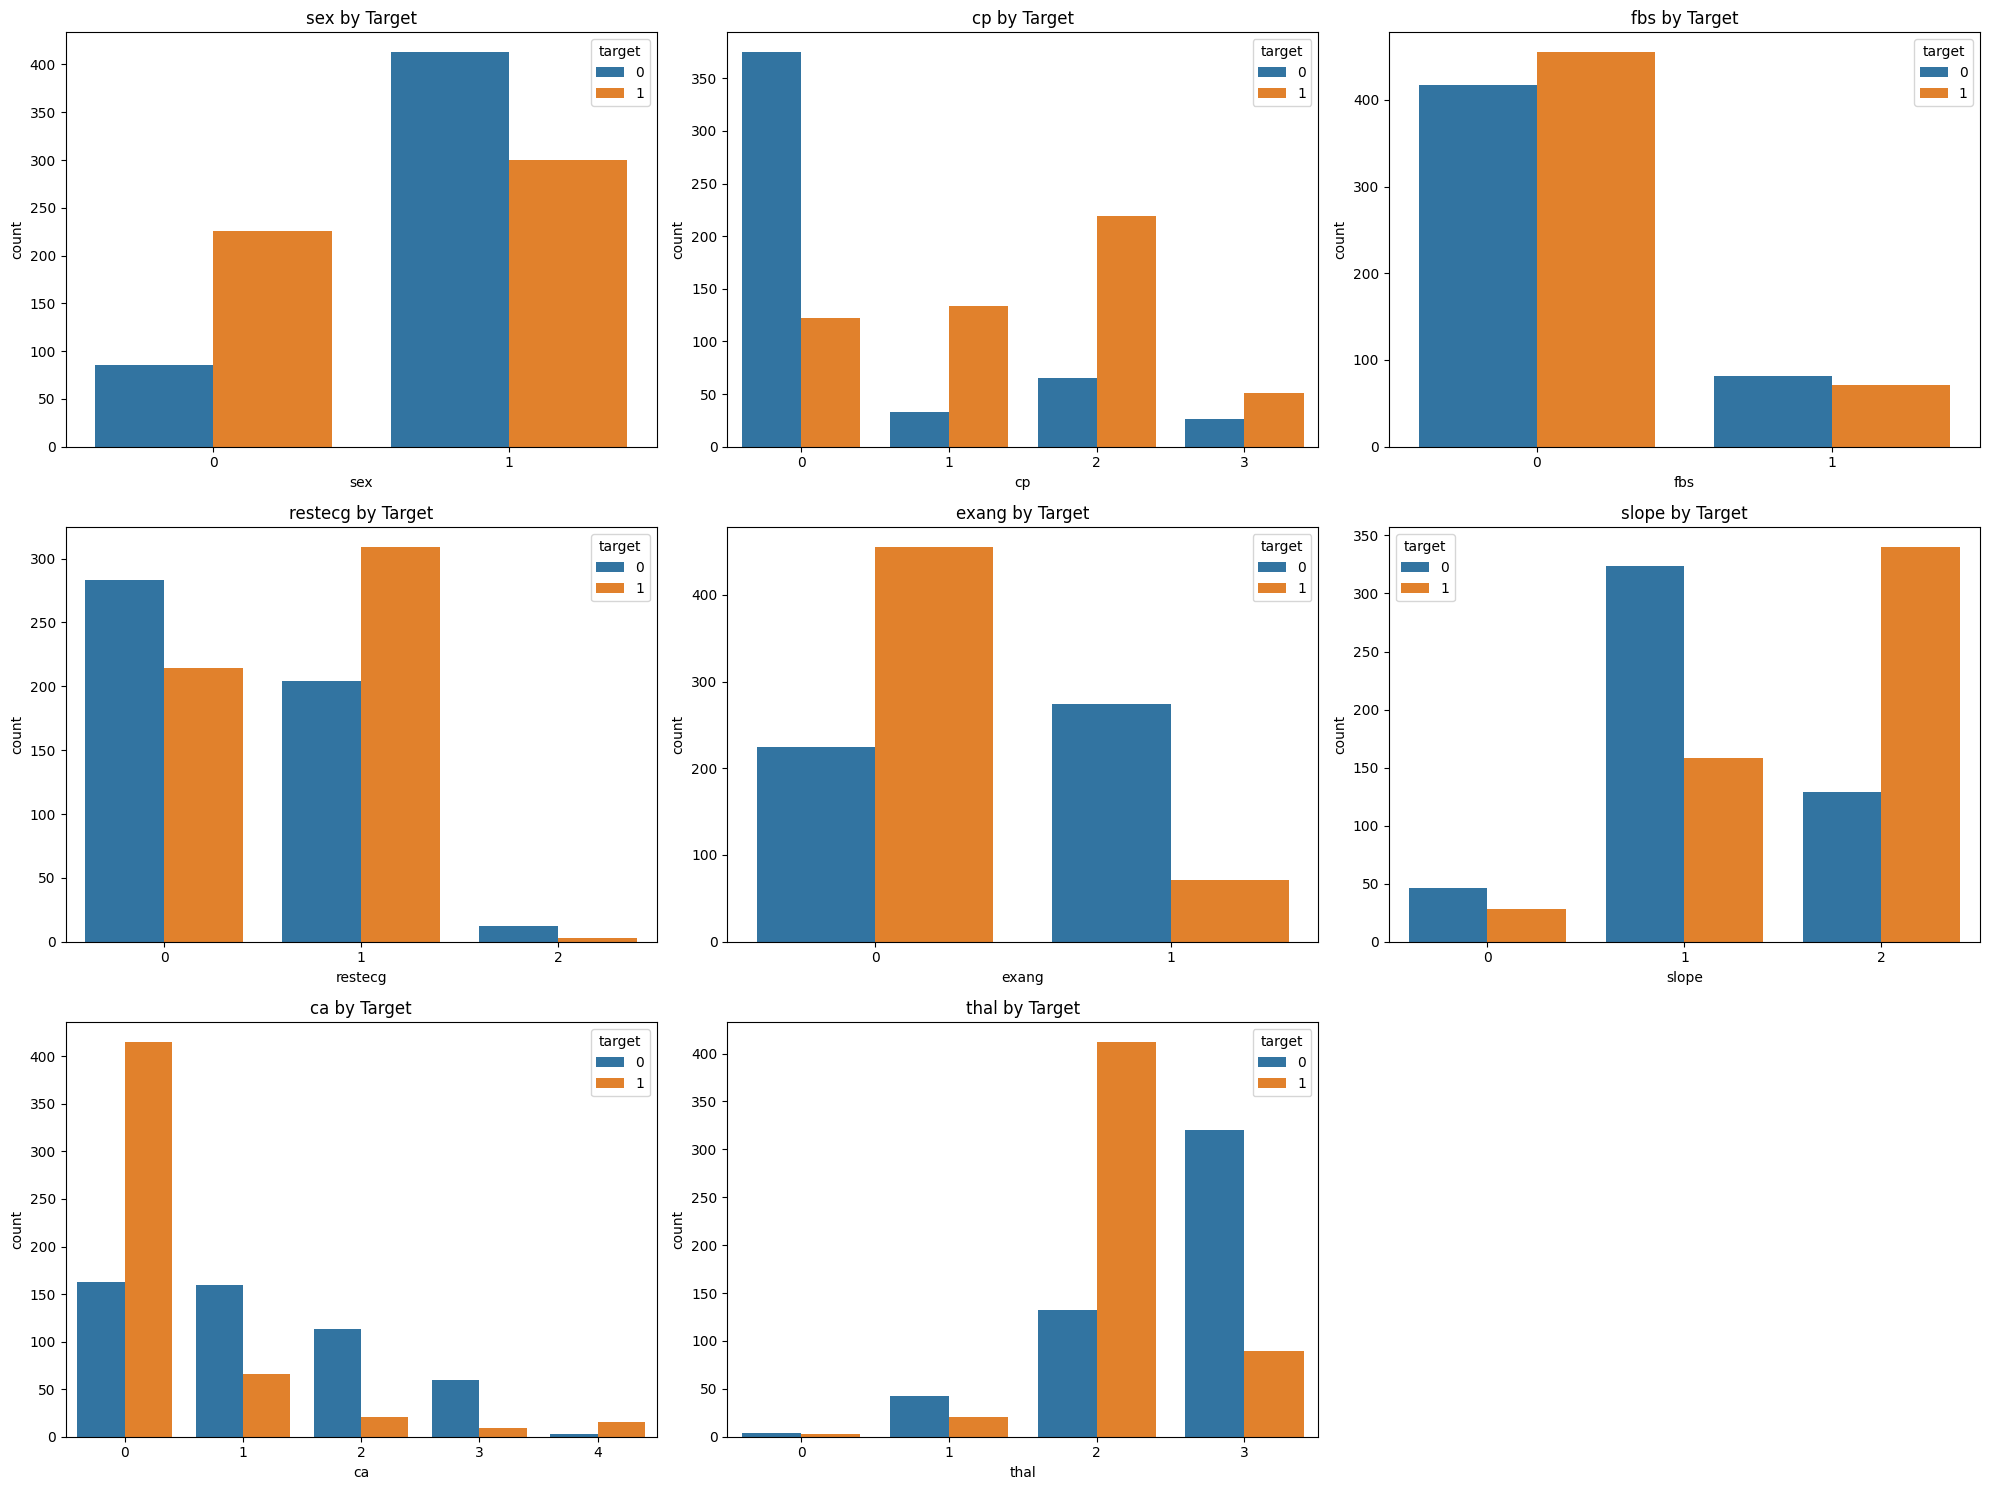


Step 3: Preprocessing data...

Step 4: Training model...

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}

Step 5: Evaluating model...

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



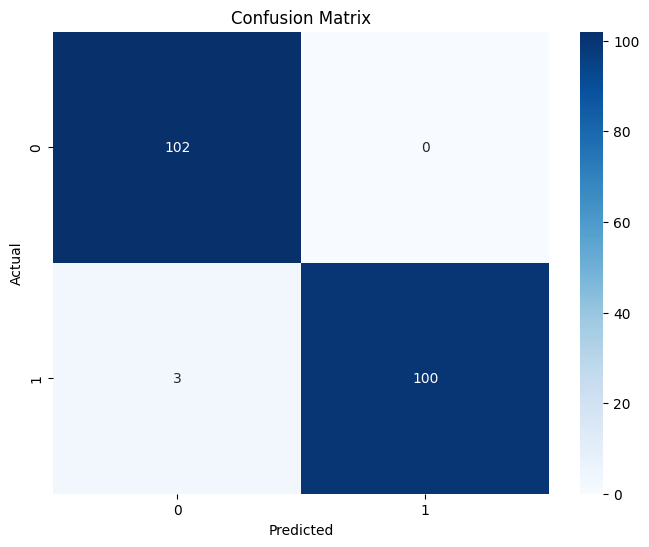

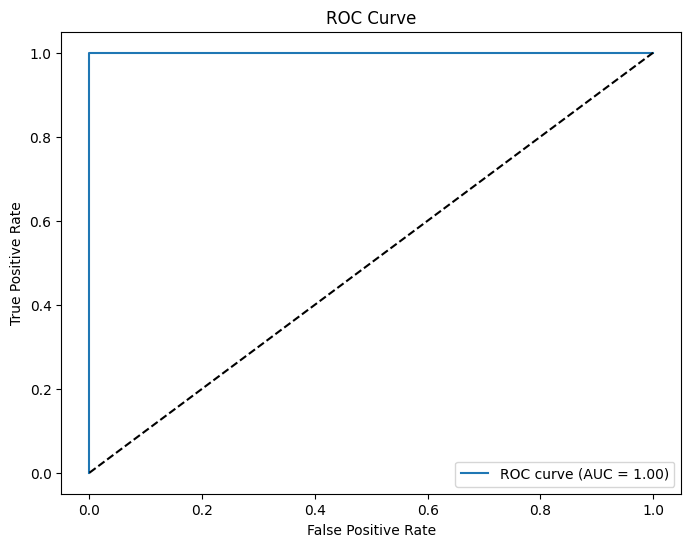

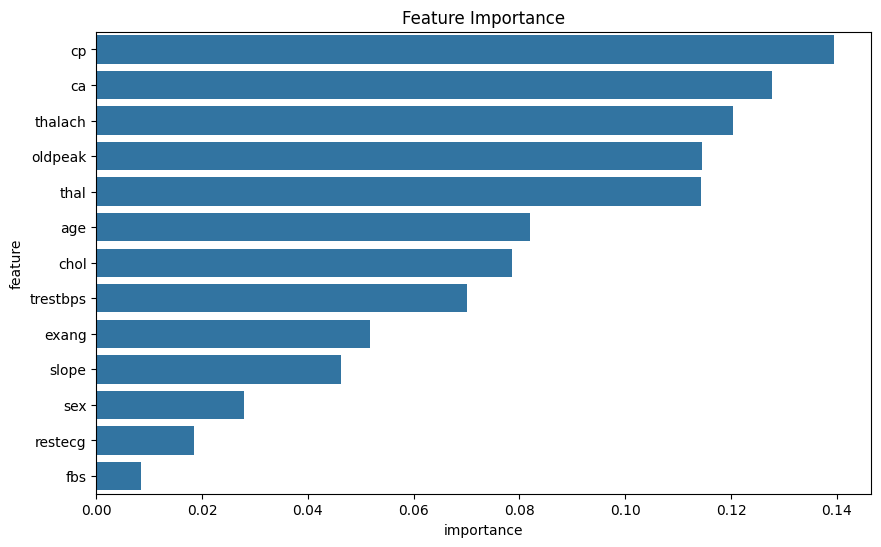


Cross-validation scores: [0.99390244 0.9695122  1.         0.98780488 0.95731707]
Average CV score: 0.982 (+/- 0.032)

Step 6: Analyzing feature impact...


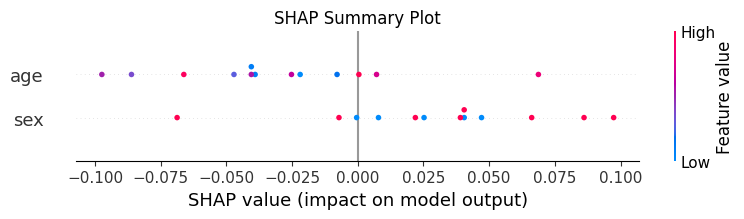

<Figure size 1000x800 with 0 Axes>

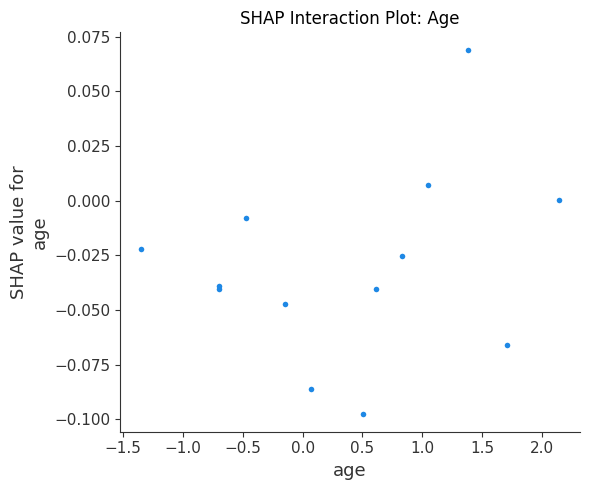


Step 7: Example prediction...

Prediction for sample patient:
Heart Disease: Yes
Probability: 0.69


In [25]:
def main():
    # Create instance of HeartDiseasePredictor
    predictor = HeartDiseasePredictor()

    # Step 1: Load data
    print("Step 1: Loading data...")
    predictor.load_data()

    # Step 2: Explore data
    print("\nStep 2: Exploring data...")
    predictor.explore_data()

    # Step 3: Preprocess data
    print("\nStep 3: Preprocessing data...")
    predictor.preprocess_data()

    # Step 4: Train model
    print("\nStep 4: Training model...")
    predictor.train_model()

    # Step 5: Evaluate model
    print("\nStep 5: Evaluating model...")
    predictor.evaluate_model()

    # Step 6: Analyze feature impact
    print("\nStep 6: Analyzing feature impact...")
    predictor.analyze_feature_impact()

    # Example prediction
    print("\nStep 7: Example prediction...")
    sample_patient = {
        'age': 65,
        'sex': 1,
        'cp': 0,
        'trestbps': 140,
        'chol': 250,
        'fbs': 0,
        'restecg': 0,
        'thalach': 150,
        'exang': 0,
        'oldpeak': 1.5,
        'slope': 1,
        'ca': 0,
        'thal': 2
    }

    result = predictor.make_prediction(sample_patient)
    print("\nPrediction for sample patient:")
    print(f"Heart Disease: {'Yes' if result['prediction'] == 1 else 'No'}")
    print(f"Probability: {result['probability']:.2f}")

if __name__ == "__main__":
    main()